# Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras import backend as K
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Mengatur seed untuk membuat eksperimen lebih dapat direproduksi.
import tensorflow as tf
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(0)
seed_everything()

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

In [ ]:
# Colab Libs...
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Importing Libraries
#ref - https://buomsoo-kim.github.io/colab/2018/04/16/Importing-files-from-Google-Drive-in-Google-Colab.md/

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
#Import Folder ke Google Drive
import os
os.chdir('/content/drive/My Drive/TESIS-CODE')
print("We are currently in the folder of ",os.getcwd())

# Load data

In [ ]:
train = pd.read_csv('./train.csv')
test = pd.read_csv('./test.csv')
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


# Model parameters

In [ ]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 30
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 224
WIDTH = 224
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [ ]:
def kappa(y_true, y_pred, n_classes=5):
    y_trues = K.cast(K.argmax(y_true), K.floatx())
    y_preds = K.cast(K.argmax(y_pred), K.floatx())
    n_samples = K.cast(K.shape(y_true)[0], K.floatx())
    distance = K.sum(K.abs(y_trues - y_preds))
    max_distance = n_classes - 1

    kappa_score = 1 - ((distance**2) / (n_samples * (max_distance**2)))

    return kappa_score

# Train test split

In [ ]:
X_train, X_val = train_test_split(train, test_size=0.20, random_state=0)

# Data generator

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=360,
                                 brightness_range=[0.5, 1.5],
                                 zoom_range=[1, 1.2],
                                 zca_whitening=True,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode='reflect',
                                 cval=0.)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory="./train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH))

valid_generator=train_datagen.flow_from_dataframe(
    dataframe=X_val,
    directory="./train_images/",
    x_col="id_code",
    y_col="diagnosis",
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    target_size=(HEIGHT, WIDTH))

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test,
        directory = "./test_images/",
        x_col="id_code",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


# Model

In [ ]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights=None,
                                       include_top=False,
                                       input_tensor=input_tensor)
    # base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    base_model.load_weights('./resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',by_name=True)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)

    return model

# Train top layers (Arsitektur Deep Learning Model ResNet50)

In [ ]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

diagnosis_values = train['diagnosis'].astype('int').values
classes = np.unique(diagnosis_values)
class_counts = np.bincount(diagnosis_values)
class_weights = len(diagnosis_values) / (len(classes) * class_counts)
class_weight_dict = dict(enumerate(class_weights))

metric_list = ["accuracy", kappa]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

179 layer

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit(train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     class_weight=class_weight_dict,
                                     verbose=1).history

Epoch 1/2
366/366 [==============================] - 2110s 6s/step - loss: 1.6386 - accuracy: 0.1879 - kappa: -0.5452 - val_loss: 1.6357 - val_accuracy: 0.1058 - val_kappa: 0.1034
Epoch 2/2
366/366 [==============================] - 529s 1s/step - loss: 1.6212 - accuracy: 0.1719 - kappa: -0.2896 - val_loss: 1.6301 - val_accuracy: 0.0412 - val_kappa: -1.1221


# Fine-tune the complete model

In [ ]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy",  metrics=metric_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
history_finetunning = model.fit(train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          class_weight=class_weight_dict,
                                          verbose=1).history

Epoch 1/30
366/366 [==============================] - 506s 1s/step - loss: 5.8713 - accuracy: 0.2393 - kappa: -0.4352 - val_loss: 1.7242 - val_accuracy: 0.0975 - val_kappa: 0.3320 - lr: 1.0000e-04
Epoch 2/30
366/366 [==============================] - 540s 1s/step - loss: 2.7561 - accuracy: 0.2201 - kappa: -0.4658 - val_loss: 2.0218 - val_accuracy: 0.1552 - val_kappa: -0.0959 - lr: 1.0000e-04
Epoch 3/30
366/366 [==============================] - 538s 1s/step - loss: 2.3065 - accuracy: 0.2472 - kappa: -0.3352 - val_loss: 1.8853 - val_accuracy: 0.2940 - val_kappa: 0.3965 - lr: 1.0000e-04
Epoch 4/30
366/366 [==============================] - ETA: 0s - loss: 2.0015 - accuracy: 0.2674 - kappa: -0.2938
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
366/366 [==============================] - 537s 1s/step - loss: 2.0015 - accuracy: 0.2674 - kappa: -0.2938 - val_loss: 1.8531 - val_accuracy: 0.2912 - val_kappa: 0.0440 - lr: 1.0000e-04
Epoch 5/30
366/366 [=============

**feature map**

In [ ]:
# Mengambil output dari lapisan ke-50
layer_name = 'conv5_block3_out'
intermediate_layer_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

# Mengambil contoh gambar
sample_image = ...  # Masukkan gambar yang ingin Anda gunakan

# Melakukan prediksi untuk mendapatkan feature map
sample_image = np.expand_dims(sample_image, axis=0)
feature_map = intermediate_layer_model.predict(sample_image)

# Menampilkan shape dari feature map
print("Shape feature map:", feature_map.shape)

In [ ]:
# Load pre-trained ResNet50 model
model = ResNet50(weights='imagenet', include_top=False)

# Load and preprocess input image
img_path = 'path_to_your_image.jpg'  # Path to your input image
img = image.load_img(img_path, target_size=(244, 244))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# Get feature map
feature_maps = model.predict(x)

# Print the shape of the feature map
print(feature_maps.shape)

# Model loss graph

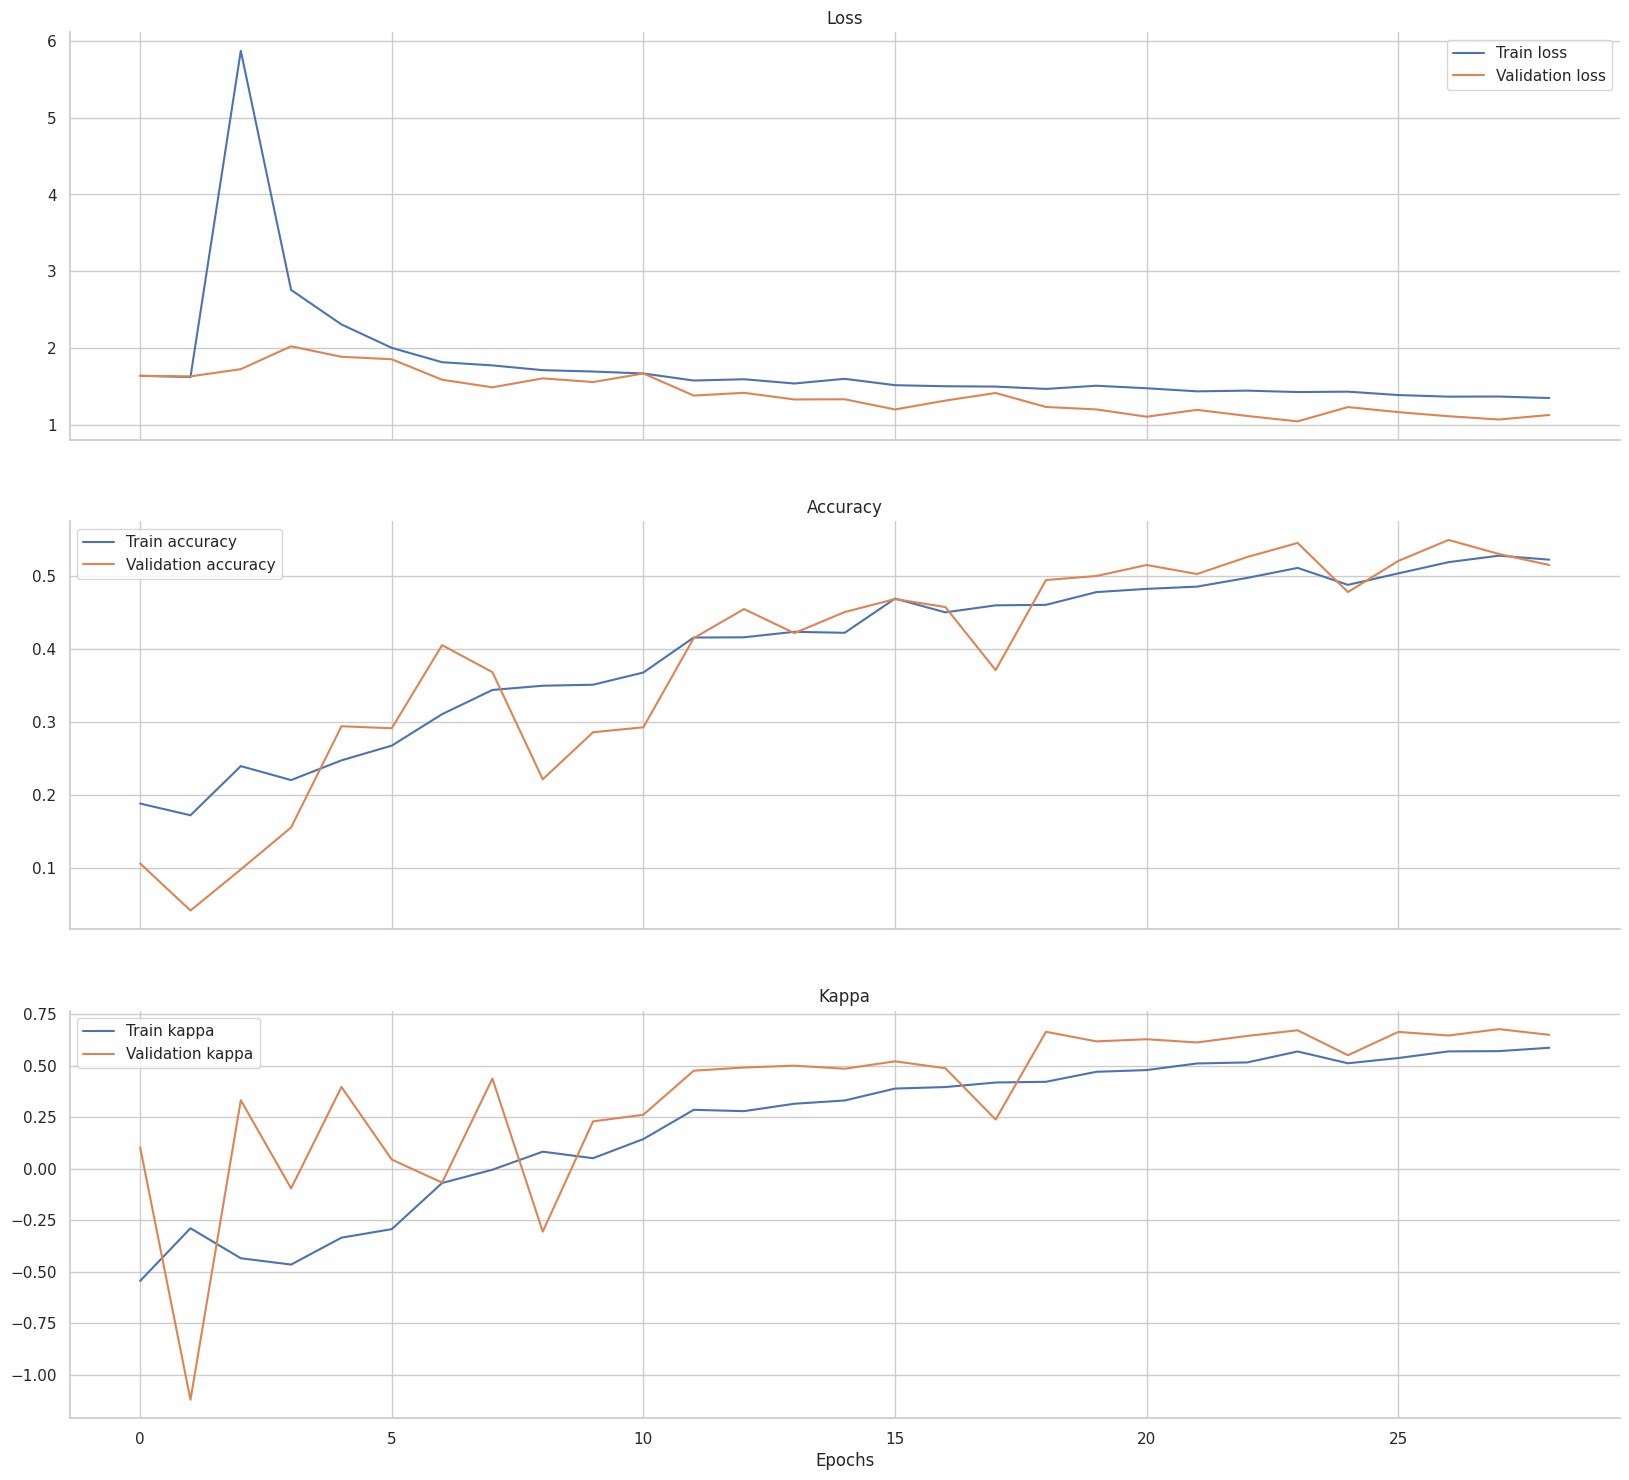

In [ ]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'],
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'],
           'accuracy': history_warmup['accuracy'] + history_finetunning['accuracy'],
           'val_accuracy': history_warmup['val_accuracy'] + history_finetunning['val_accuracy'],
           'kappa': history_warmup['kappa'] + history_finetunning['kappa'],
           'val_kappa': history_warmup['val_kappa'] + history_finetunning['val_kappa']}

sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex='col', figsize=(20, 18))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['accuracy'], label='Train accuracy')
ax2.plot(history['val_accuracy'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

ax3.plot(history['kappa'], label='Train kappa')
ax3.plot(history['val_kappa'], label='Validation kappa')
ax3.legend(loc='best')
ax3.set_title('Kappa')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [ ]:
# Membuat array kosong untuk menyimpan prediksi dan label
lastFullTrainPred = np.empty((0, N_CLASSES))
lastFullTrainLabels = np.empty((0, N_CLASSES))
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

# Menambahkan prediksi dan label pada data latih
for i in range(STEP_SIZE_TRAIN+1):
    im, lbl = next(train_generator)
    scores = model.predict(im, batch_size=train_generator.batch_size)
    lastFullTrainPred = np.append(lastFullTrainPred, scores, axis=0)
    lastFullTrainLabels = np.append(lastFullTrainLabels, lbl, axis=0)

# Menambahkan prediksi dan label pada data validasi
for i in range(STEP_SIZE_VALID+1):
    im, lbl = next(valid_generator)
    scores = model.predict(im, batch_size=valid_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)

1/1 [==============================] - 1s 981ms/step


# Threshold optimization

thr=0.280 F2=0.376


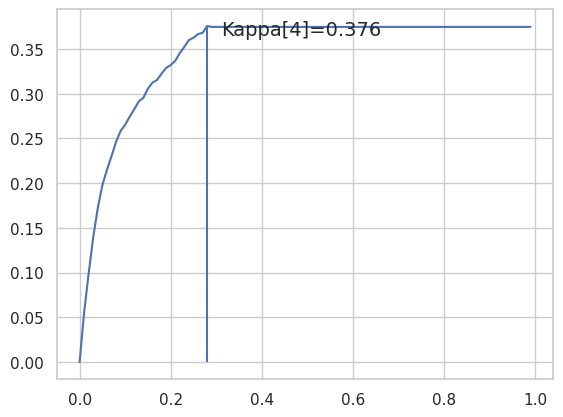

thr=0.310 F2=0.375


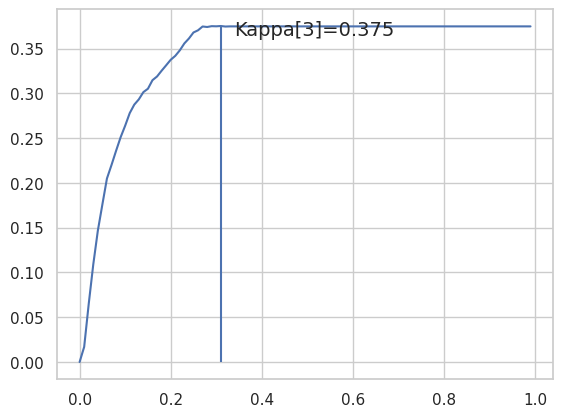

thr=0.200 F2=0.480


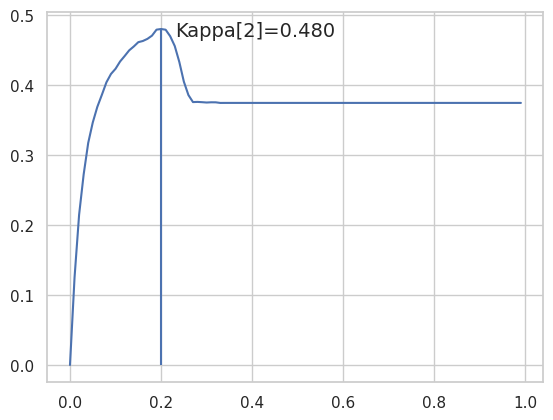

thr=0.440 F2=0.375


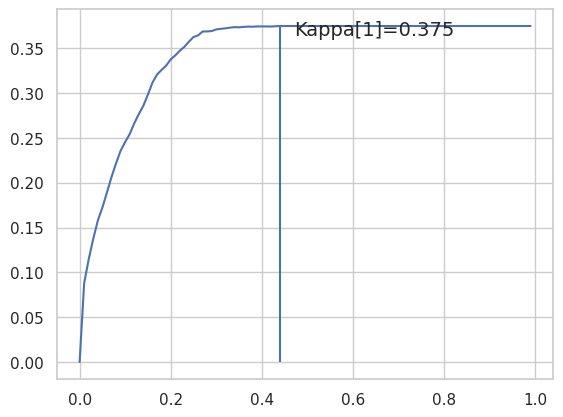

In [ ]:
def find_best_fixed_threshold(preds, targs, do_plot=True):
    best_thr_list = [0 for i in range(preds.shape[1])]
    for index in reversed(range(1, preds.shape[1])):
        score = []
        thrs = np.arange(0, 1, 0.01)
        for thr in thrs:
            preds_thr = [index if x[index] > thr else np.argmax(x) for x in preds]
            score.append(cohen_kappa_score(targs, preds_thr))
        score = np.array(score)
        pm = score.argmax()
        best_thr, best_score = thrs[pm], score[pm].item()
        best_thr_list[index] = best_thr
        print(f'thr={best_thr:.3f}', f'F2={best_score:.3f}')
        if do_plot:
            plt.plot(thrs, score)
            plt.vlines(x=best_thr, ymin=score.min(), ymax=score.max())
            plt.text(best_thr+0.03, best_score-0.01, ('Kappa[%s]=%.3f'%(index, best_score)), fontsize=14);
            plt.show()

    return best_thr_list

lastFullComPred = np.concatenate((lastFullTrainPred, lastFullValPred))
lastFullComLabels = np.concatenate((lastFullTrainLabels, lastFullValLabels))
complete_labels = [np.argmax(label) for label in lastFullComLabels]

threshold_list = find_best_fixed_threshold(lastFullComPred, complete_labels, do_plot=True)
threshold_list[0] = 0 # In last instance assign label 0

train_preds = [np.argmax(pred) for pred in lastFullTrainPred]
train_labels = [np.argmax(label) for label in lastFullTrainLabels]
validation_preds = [np.argmax(pred) for pred in lastFullValPred]
validation_labels = [np.argmax(label) for label in lastFullValLabels]

In [ ]:
# Menerapkan ambang batas yang dioptimalkan pada prediksi data latih
train_preds_opt = [0 for i in range(lastFullTrainPred.shape[0])]
for idx, thr in enumerate(threshold_list):
    for idx2, pred in enumerate(lastFullTrainPred):
        if pred[idx] > thr:
            train_preds_opt[idx2] = idx

# Menerapkan ambang batas yang dioptimalkan pada prediksi data validasi
validation_preds_opt = [0 for i in range(lastFullValPred.shape[0])]
for idx, thr in enumerate(threshold_list):
    for idx2, pred in enumerate(lastFullValPred):
        if pred[idx] > thr:
            validation_preds_opt[idx2] = idx

# Model Evaluation

## Confusion Matrix

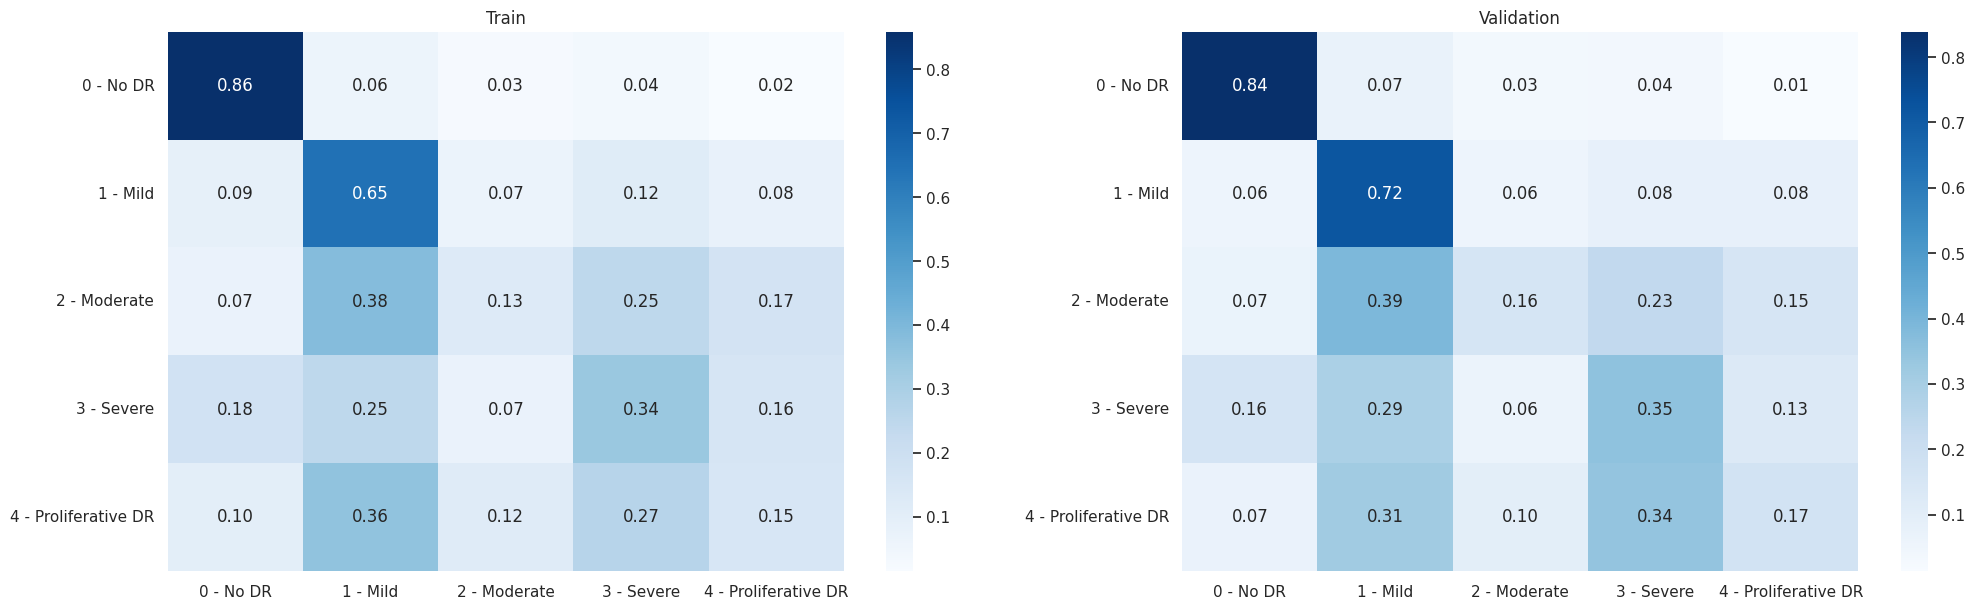

In [ ]:
# Original thresholds
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
train_cnf_matrix = confusion_matrix(train_labels, train_preds)
validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train')
sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax2).set_title('Validation')
plt.show()

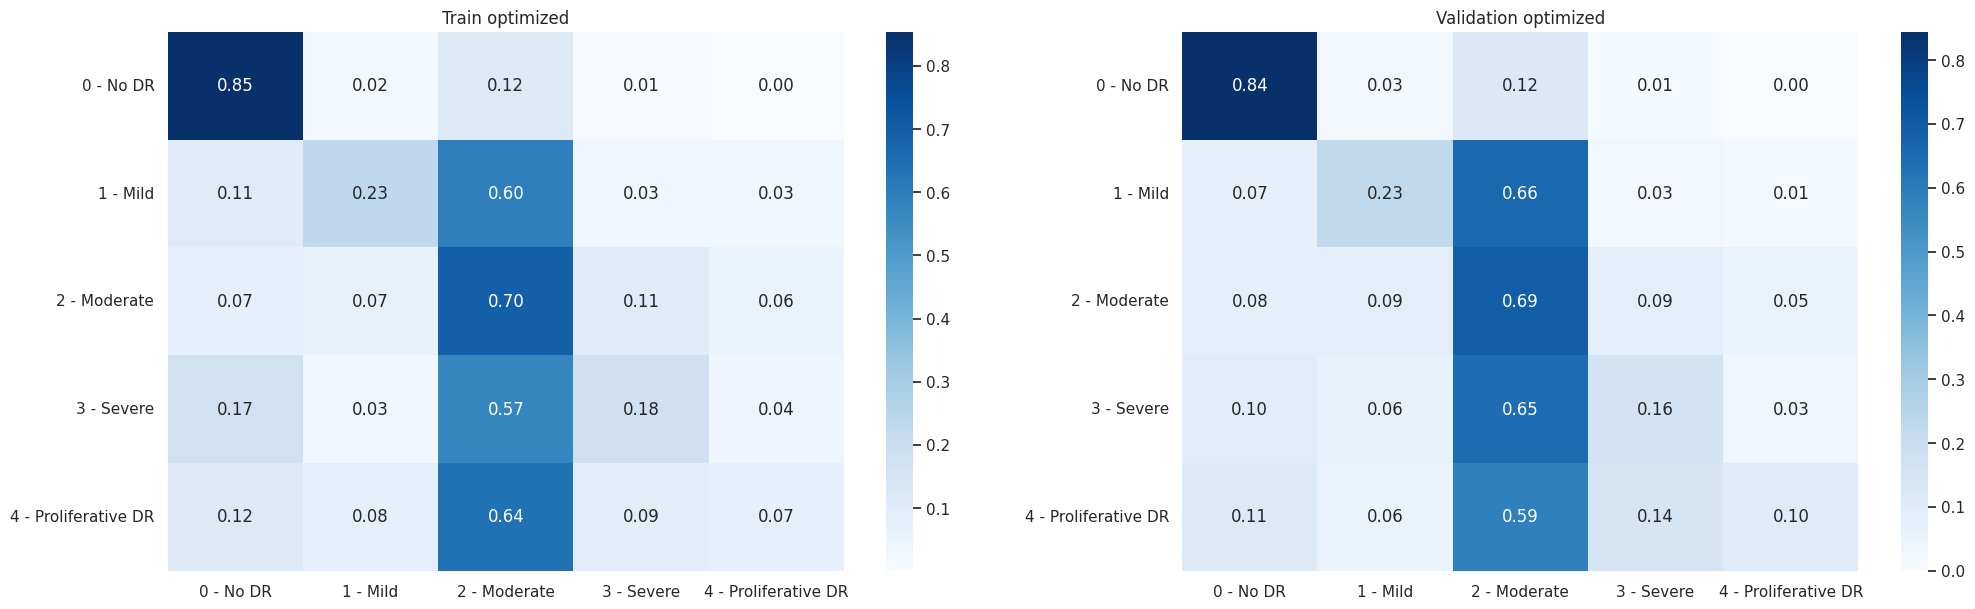

In [ ]:
# Optimized thresholds
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
train_cnf_matrix = confusion_matrix(train_labels, train_preds_opt)
validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds_opt)

train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train optimized')
sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax2).set_title('Validation optimized')
plt.show()

## Quadratic Weighted Kappa

In [ ]:
print(" --- Original thresholds --- ")
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train_labels, weights='quadratic'))
print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds+validation_preds, train_labels+validation_labels, weights='quadratic'))
print(" --- Optimized thresholds --- ")
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds_opt, train_labels, weights='quadratic'))
print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds_opt, validation_labels, weights='quadratic'))
print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds_opt+validation_preds_opt, train_labels+validation_labels, weights='quadratic'))

 --- Original thresholds --- 
Train Cohen Kappa score: 0.559
Validation Cohen Kappa score: 0.578
Complete set Cohen Kappa score: 0.563
 --- Optimized thresholds --- 
Train Cohen Kappa score: 0.627
Validation Cohen Kappa score: 0.634
Complete set Cohen Kappa score: 0.628


## Apply model to test set and output predictions

In [ ]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

predictions_opt = [0 for i in range(preds.shape[0])]
for idx, thr in enumerate(threshold_list):
    for idx2, pred in enumerate(preds):
        if pred[idx] > thr:
            predictions_opt[idx2] = idx

filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])

results_opt = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions_opt})
results_opt['id_code'] = results_opt['id_code'].map(lambda x: str(x)[:-4])

# Predictions class distribution

In [ ]:
    # Menggunakan np.unique untuk mendapatkan daftar semua nama kelas
    classes = np.unique(predictions)

    # Menampilkan daftar semua nama kelas
    print(classes)

[0 1 2 3 4]


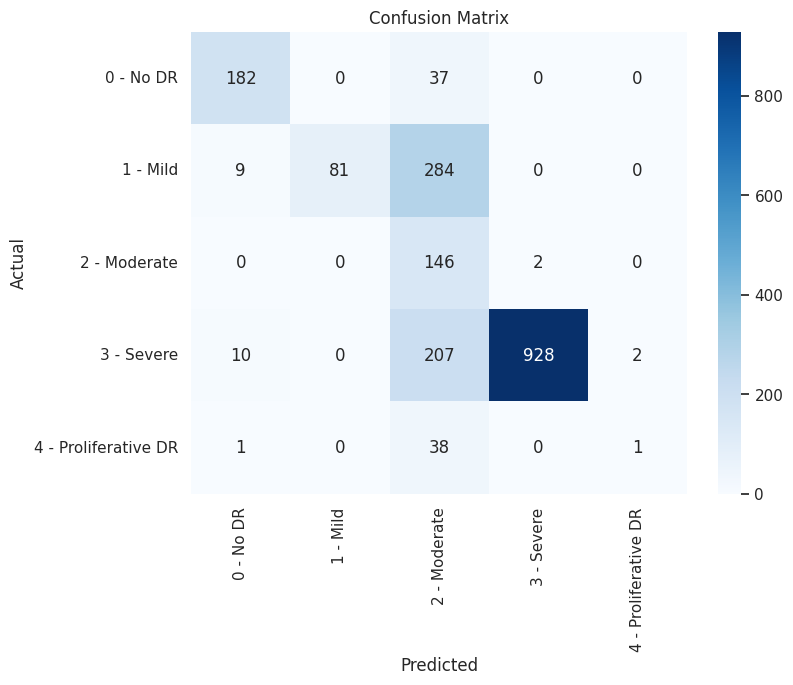

In [ ]:
# Daftar label
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']

# Menghitung confusion matrix
cm = confusion_matrix(results['diagnosis'], results_opt['diagnosis'])

# Menampilkan matriks kebingungan dalam bentuk heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

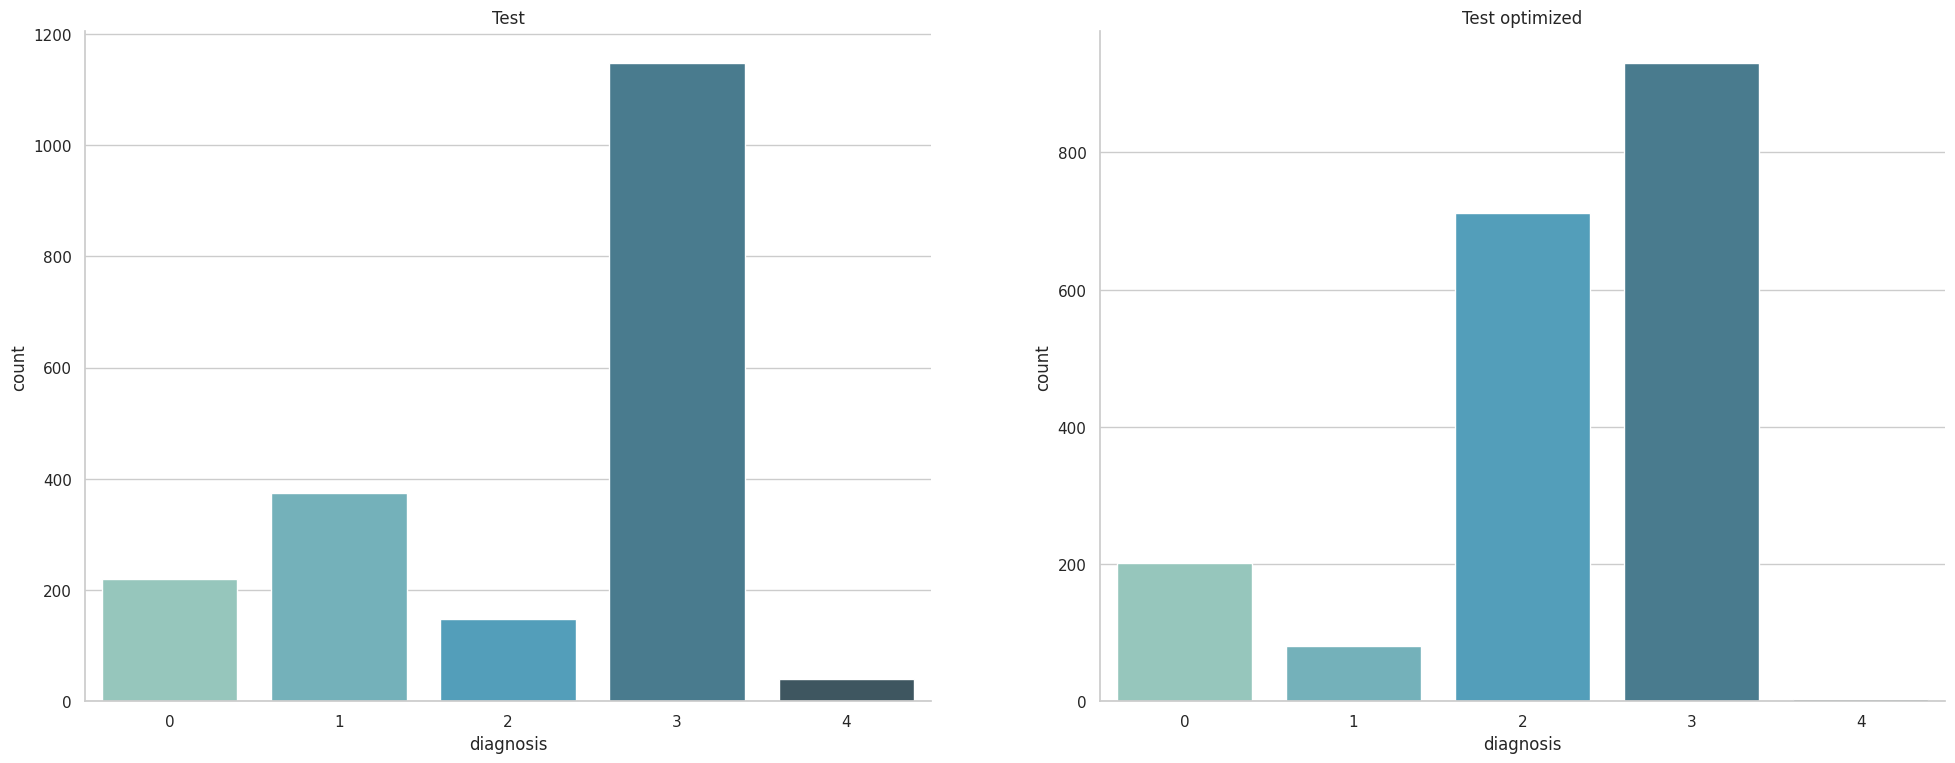

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=results, palette="GnBu_d", ax=ax1).set_title('Test')
sns.countplot(x="diagnosis", data=results_opt, palette="GnBu_d", ax=ax2).set_title('Test optimized')
sns.despine()
plt.show()

In [ ]:
val_kappa =  cohen_kappa_score(validation_preds, validation_labels, weights='quadratic')
val_opt_kappa = cohen_kappa_score(validation_preds_opt, validation_labels, weights='quadratic')
if val_kappa > val_opt_kappa:
    results_name = 'submission.csv'
    results_opt_name = 'submission_opt.csv'
else:
    results_name = 'submission_norm_ResNet50.csv'
    results_opt_name = 'submission.csv'

results.to_csv(results_name, index=False)
results.head(10)

,id_code,diagnosis
0,0005cfc8afb6,1
1,003f0afdcd15,3
2,006efc72b638,3
3,00836aaacf06,1
4,009245722fa4,3
5,009c019a7309,3
6,010d915e229a,3
7,0111b949947e,0
8,01499815e469,3
9,0167076e7089,0


In [ ]:
results_opt.to_csv(results_opt_name, index=False)
results_opt.head(10)

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,3
5,009c019a7309,3
6,010d915e229a,2
7,0111b949947e,0
8,01499815e469,3
9,0167076e7089,0
